In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
import regex as re
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import math
import tensorflow as tf
import h5py
import copy
import time
import datetime
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from scipy.special import softmax
from copy import deepcopy
from sklearn.metrics import roc_curve, roc_auc_score, mean_absolute_error, auc, r2_score
import seaborn
from torch.autograd import Variable

LOCAL = True
BASE_DIR = '../'

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
from preprocessing import process_sakt, save_h5
import dataset_parameters as params

# DATASET = 'akribian'
# DATASET = 'assistments_2009'
# DATASET = 'assistments_2012'
DATASET = 'junyi_academy'
# DATASET = 'ednet'

TIME_STEPS = params.time_steps_dict[DATASET]

# File paths
IN_DATA_PATH = BASE_DIR + 'data/' + DATASET + '/processed/sakt/' 
INPUT_PATH = IN_DATA_PATH + "processed.h5"
MODEL_PATH = BASE_DIR + 'models/keetar/' 

# Training parameters
BATCH_SIZE = 16
LATENT_DIM = 128 # latent dimension
PADDING = 0
SHUFFLE = True
TIME_STEPS = params.time_steps_dict[DATASET]
#EPOCHS = params.epochs_dict[DATASET]
EPOCHS = 100
NUMBER_OF_EXERCISES = params.exercise_dict[DATASET]
NUMBER_OF_IDS = params.exercise_id_dict[DATASET]
ROWS_PER_READ = 100000
HEADS_EN = 8
LAYERS_EN = 1
HEADS_DE = 2
LAYERS_DE = 2
WARMUP = 4000
DROPOUT = 0.2
LSTM_LAYERS = 1

# Use only last query to reduce matmul complexity for long sequences at the cost of performance hit
USE_Q_TRICK = False

# Whether to load relation matrix from file to augment attention weights
USE_RELATION_MATRIX = False
# Whether to preload entire relation matrix into GPU memory
PRELOAD_RELATION_MATRIX = False
# Whether to use time features
USE_ELAPSED = False
USE_TIMESTAMP = False
# Whether to use the per-question z-scored version of elapsed time feature
ZSCORE_ELAPSED = True
# Whether to normalize time features to [0, 1]
NORMALIZE_TIME_FEATURES = False
# Sparsity threshold for relation matrix
THETA = 0.5
# Mixing coefficient for relation matrix
LAMBDA = 0.5
# Whether to concatenate the embeddings instead of adding
CONCATENATE_EMBEDDINGS = True
# Whether to mean the embeddings when not using concatenation
MEAN_EMBEDDINGS = False
# Whether to use interactions instead of past answers
USE_INTERACTIONS = False

# How many iterations without improvement to wait before interrupting training
EARLY_STOPPING_TOLERANCE = 3

In [2]:
print("CUDA available: %i" % torch.cuda.is_available())
cuda = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

CUDA available: 1


# Model class

In [3]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def zero_grad(self):
        self.optimizer.zero_grad()

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Multihead attention

In [4]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #print(pe.shape)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def attention(query, key, value, mask=None, dropout=None, relation_matrix = None, q_trick = False):
    "Compute 'Scaled Dot Product Attention'"
    # Data is in the format (b,h,n,d_k)
    d_k = key.size(-1)
    n = key.size(-2)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
                / math.sqrt(d_k)
    # scores is in the shape (b, h, n, n)
    # mask is in the shape (b, h, n, n)
    if mask is not None:
        scores = scores.masked_fill(~mask, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    p_attn = torch.where(torch.isnan(p_attn), torch.zeros_like(p_attn), p_attn)
    if relation_matrix is not None:
        p_attn = LAMBDA * p_attn + (1 - LAMBDA) * relation_matrix
        # scores = (relation_matrix + LAMBDA) * scores
    if mask is not None:
        p_attn = p_attn.masked_fill(~mask, 0.)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiheadAttention(nn.Module):
    def __init__(self, number_of_heads, dim_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiheadAttention, self).__init__()
        assert dim_model % number_of_heads == 0
        # We assume d_v always equals d_k
        self.d_k = dim_model // number_of_heads
        self.h = number_of_heads
        self.linears = nn.ModuleList([nn.Linear(dim_model, dim_model) for _ in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None, padding_mask=None, relation_matrix=None, q_trick = False):

        "Implements Figure 2"
        # if mask is not None:
        #     # Same mask applied to all h heads.
        #     mask = mask.unsqueeze(1)
        nbatches = key.size(0)
        seq_len = key.size(1)
        
        # right now the data is in the shape (b,n,d_model)
        # 1) Do all the linear projections in batch from d_model => h x d_k and then transposed to swap dim of h and n
        # q,k,v will each have shape (b, h, n, d_k)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        # mask has shape (n, n)
        if not USE_Q_TRICK:
            mask = mask.unsqueeze(0).unsqueeze(0).repeat(nbatches, self.h, 1, 1) # (n,n) -> (b,h,n,n)
        # padding mask has shape (b, n)
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(1).repeat(1, self.h, 1, 1) # (b,n) -> (b,h,n,n)
        # data has shape (b, h, n, d_k)
        x, self.attn = attention(query, key, value,                       
                                 mask=padding_mask if q_trick else mask * padding_mask,
                                 dropout=self.dropout,
                                 relation_matrix=relation_matrix,
                                 q_trick = q_trick)

        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class Feed_Forward_block(nn.Module):
    """
    out =  Relu( M_out*w1 + b1) *w2 + b2
    """
    def __init__(self, dim_ff):
        super().__init__()
        self.layer1 = nn.Linear(in_features=dim_ff , out_features=dim_ff)
        self.layer2 = nn.Linear(in_features=dim_ff , out_features=dim_ff)

    def forward(self,ffn_in):
        return  self.layer2(   F.relu( self.layer1(ffn_in) )   )
        

class Encoder_block(nn.Module):
    """
    M = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    O = SkipConct(FFN(LayerNorm(M)))
    """

    def __init__(self, dim_model, heads_en, dropout):
        super().__init__()
        
        self.multi_en = MultiheadAttention( number_of_heads = heads_en, dim_model = dim_model, dropout = dropout  )
        self.ffn_en = Feed_Forward_block( dim_model )
        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, in_ex, relation_matrix = None, padding_mask = None, q_trick = False, query = None):

        # input is batch-first (b,n,d)
        out = in_ex                                      # Applying positional embedding

        # out = out.permute(1,0,2)                         # -> (n,b,d)

        # index for last query
        if query is None:
            if q_trick:
                query = out[:,-1,:]
            else:
                query = out

        #Multihead attention                            
        b,n,d = out.shape
        out = self.layer_norm1( out )                           # Layer norm
        skip_out = out
        # attention function accepts batch-first format
        out = self.multi_en( query , out , out ,
                                mask=subsequent_mask(n)
                                ,padding_mask = padding_mask 
                                ,relation_matrix = relation_matrix
                                ,q_trick = q_trick
                                )  # attention mask upper triangular
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        #feed forward
        # out = out.permute(1,0,2)                                # -> (b,n,d)
        out = self.layer_norm2( out )                           # Layer norm 
        skip_out = out
        out = self.ffn_en( out )
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        return out

class Decoder_block(nn.Module):
    """
    M1 = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    M2 = SkipConct(Multihead(LayerNorm(M1;O;O)))
    L = SkipConct(FFN(LayerNorm(M2)))
    """

    def __init__(self, dim_model, heads_de, dropout):
        super().__init__()

        self.multi_de1  = MultiheadAttention( dim_model= dim_model, number_of_heads= heads_de, dropout=dropout  )  # M1 multihead for interaction embedding as q k v
        self.multi_de2  = MultiheadAttention( dim_model= dim_model, number_of_heads= heads_de, dropout=dropout  )  # M2 multihead for M1 out, encoder out, encoder out as q k v
        self.ffn_en     = Feed_Forward_block( dim_model )                                         # feed forward layer

        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.layer_norm3 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, in_in, en_out, padding_mask = None):

        ## todo create a positional encoding ( two options numeric, sine)

        out = in_in
        b,n,d = out.shape

        #Multihead attention M1                                     ## todo verify if E to passed as q,k,v
        out = self.layer_norm1( out )
        skip_out = out
        out = self.multi_de1( out , out , out ,
                        mask=subsequent_mask(n)
                        ,padding_mask = padding_mask 
                        )  # attention mask upper triangular
        out = skip_out + out                                        # skip connection
        out = self.dropout(out)

        #Multihead attention M2                                     ## todo verify if E to passed as q,k,v
        en_out = self.layer_norm2( en_out )
        skip_out = out
        out = self.multi_de2( out , en_out , en_out,
                                    mask=subsequent_mask(n)
                                    ,padding_mask = padding_mask )  # attention mask upper triangular
        out = out + skip_out
        out = self.dropout(out)

        #feed forward
        out = self.layer_norm3( out )                               # Layer norm 
        skip_out = out
        out = self.ffn_en( out )                                    
        out = out + skip_out                                        # skip connection
        out = self.dropout(out)

        return out

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_mask(seq_len):
    ##todo add this to device
    return torch.from_numpy( np.triu(np.ones((seq_len ,seq_len)), k=1).astype('bool')).cuda()

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (size, size)
    subsequent_mask = np.tril(np.ones(attn_shape), k=0).astype('uint8')
    return torch.from_numpy(subsequent_mask).cuda() == 1

def get_pos(seq_len):
    # use sine positional embeddinds
    return torch.arange( seq_len ).unsqueeze(0)
    #return torch.arange( seq_len ).unsqueeze(1)



## SAINT

In [5]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #print(pe.shape)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

class Feed_Forward_block(nn.Module):
    """
    out =  Relu( M_out*w1 + b1) *w2 + b2
    """
    def __init__(self, dim_ff):
        super().__init__()
        self.layer1 = nn.Linear(in_features=dim_ff , out_features=dim_ff)
        self.layer2 = nn.Linear(in_features=dim_ff , out_features=dim_ff)

    def forward(self,ffn_in):
        return  self.layer2(   F.relu( self.layer1(ffn_in) )   )
        

class Saint_Encoder_block(nn.Module):
    """
    M = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    O = SkipConct(FFN(LayerNorm(M)))
    """

    def __init__(self , dim_model, heads_en, total_ex ,total_cat, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.embd_ex =   nn.Embedding( total_ex , embedding_dim = dim_model )                   # embedings  q,k,v = E = exercise ID embedding, category embedding, and positionembedding.
        self.embd_cat =  nn.Embedding( total_cat, embedding_dim = dim_model )
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model )                  #positional embedding
        #self.embd_pos   = PositionalEncoding(  dim_model, 0., seq_len )                          #positional embedding

        self.multi_en = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_en,  )     # multihead attention    ## todo add dropout, LayerNORM
        self.ffn_en = Feed_Forward_block( dim_model )                                            # feedforward block     ## todo dropout, LayerNorm
        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, in_ex, in_cat, first_block=True, query=None, padding_mask = None):

        ## todo create a positional encoding ( two options numeric, sine)
        if first_block:
            in_ex = self.embd_ex( in_ex )
            in_cat = self.embd_cat( in_cat )
            #combining the embedings
            out = in_ex + in_cat                      # (b,n,d)
        else:
            out = in_ex
        
        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )
        out = out + in_pos                                      # Applying positional embedding

        out = out.permute(1,0,2) # -> (n,b,d)
        
        #Multihead attention                            
        out = self.layer_norm1( out )                           # Layer norm
        skip_out = out
        if query is None:
            query = out            
        else:
            query = query.permute(1,0,2) # -> (n,b,d)
        out, attn_wt = self.multi_en( query , out , out ,
                                attn_mask=get_mask(seq_len=self.seq_len),
                                    key_padding_mask = padding_mask)  # attention mask upper triangular
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        #feed forward
        out = out.permute(1,0,2)                                # (b,n,d)
        out = self.layer_norm2( out )                           # Layer norm 
        skip_out = out
        out = self.ffn_en( out )
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        return out


class Saint_Decoder_block(nn.Module):
    """
    M1 = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    M2 = SkipConct(Multihead(LayerNorm(M1;O;O)))
    L = SkipConct(FFN(LayerNorm(M2)))
    """

    def __init__(self,dim_model ,total_in, heads_de,seq_len, dropout  ):
        super().__init__()
        self.seq_len    = seq_len
        self.embd_in    = nn.Embedding(  total_in , embedding_dim = dim_model )                  #interaction embedding
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model )                  #positional embedding
        #self.embd_pos   = PositionalEncoding(  dim_model, 0., seq_len )
        self.multi_de1  = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_de  )  # M1 multihead for interaction embedding as q k v
        self.multi_de2  = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_de  )  # M2 multihead for M1 out, encoder out, encoder out as q k v
        self.ffn_en     = Feed_Forward_block( dim_model )                                         # feed forward layer

        self.embed_vector_elapsed = nn.Linear(1, dim_model)

        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.layer_norm3 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, in_in, en_out, first_block=True, in_elapsed = None):

         ## todo create a positional encoding ( two options numeric, sine)
        if first_block:
            in_in = self.embd_in( in_in )
            in_elapsed = self.embed_vector_elapsed(in_elapsed)

            #combining the embedings
            out = in_in + in_elapsed                         # (b,n,d)
        else:
            out = in_in

        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )
        out = out + in_pos                                          # Applying positional embedding

        out = out.permute(1,0,2)                                    # (n,b,d)# print('pre multi', out.shape )
        n,_,_ = out.shape

        #Multihead attention M1                                     ## todo verify if E to passed as q,k,v
        out = self.layer_norm1( out )
        skip_out = out
        out, attn_wt = self.multi_de1( out , out , out, 
                                     attn_mask=get_mask(seq_len=n)) # attention mask upper triangular
        out = skip_out + out                                        # skip connection
        out = self.dropout(out)

        #Multihead attention M2                                     ## todo verify if E to passed as q,k,v
        en_out = en_out.permute(1,0,2)                              # (b,n,d)-->(n,b,d)
        en_out = self.layer_norm2( en_out )
        skip_out = out
        out, attn_wt = self.multi_de2( out , en_out , en_out,
                                    attn_mask=get_mask(seq_len=n))  # attention mask upper triangular
        out = out + skip_out
        out = self.dropout(out)

        #feed forward
        out = out.permute(1,0,2)                                    # (b,n,d)
        out = self.layer_norm3( out )                               # Layer norm 
        skip_out = out
        out = self.ffn_en( out )                                    
        out = out + skip_out                                        # skip connection
        out = self.dropout(out)


        return out

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_mask(seq_len):
    ##todo add this to device
    return torch.from_numpy( np.triu(np.ones((seq_len ,seq_len)), k=1).astype('bool')).cuda()

def get_pos(seq_len):
    # use sine positional embeddinds
    return torch.arange( seq_len ).unsqueeze(0)
    #return torch.arange( seq_len ).unsqueeze(1)

class saint(nn.Module):
    def __init__(self,dim_model,num_en, num_de ,heads_en, total_ex ,total_cat, total_in, heads_de, seq_len, dropout ):
        super().__init__( )

        self.num_en = num_en
        self.num_de = num_de

        self.encoder = get_clones(Saint_Encoder_block(dim_model, heads_en, total_ex, total_cat, seq_len, dropout), num_en)
        self.decoder = get_clones(Saint_Decoder_block(dim_model ,total_in, heads_de, seq_len, dropout)           , num_de)

        self.out = nn.Linear(in_features= dim_model , out_features=1)
    
    def forward(self, in_ex, in_cat, in_in, in_elapsed=None, in_ts=None, relation_matrix=None ):
        
        padding_mask = in_ex == 0 # (batch, sequence). pytorch wants it in this format for some reason
        padding_mask = padding_mask.cuda()

        ## pass through each of the encoder blocks in sequence
        first_block = True
        for x in range(self.num_en):
            if x>=1:
                first_block = False
            in_ex = self.encoder[x]( in_ex, in_cat ,first_block=first_block)
            in_cat = in_ex                                  # passing same output as q,k,v to next encoder block

        
        ## pass through each decoder block in sequence
        first_block = True
        for x in range(self.num_de):
            if x>=1:
                first_block = False
            in_in = self.decoder[x]( in_in, en_out= in_ex, first_block=first_block, in_elapsed=in_elapsed )

        ## Output layer
        in_in = torch.sigmoid( self.out( in_in ) )
        return in_in

## MAMAS

In [6]:
class mamas(nn.Module):
    def __init__(self, dim_model, num_en, heads_en, total_ex ,total_cat, total_in, seq_len, dropout):
        super().__init__( )

        self.num_en = num_en
        self.seq_len = seq_len
        self.h = heads_en

        self.embd_ex =   nn.Embedding( total_ex, embedding_dim = dim_model ) # embedings  q,k,v = E = exercise ID embedding, category embedding, and positionembedding.
        self.embd_cat =  nn.Embedding( total_cat, embedding_dim = dim_model )
        self.embd_in = nn.Embedding( total_in, embedding_dim = dim_model )
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model ) # positional embedding

        self.embed_vector_elapsed = nn.Linear(1, dim_model)
        self.embed_vector_timestamp = nn.Linear(1, dim_model)        

        self.ffn1 = nn.Linear(4*dim_model, dim_model)
        self.ffn2 = nn.Linear(3*dim_model, dim_model)
        self.ffn3 = nn.Linear(5*dim_model, dim_model)
        self.ffn4 = nn.Linear(3*dim_model, dim_model)        
        self.encoder = get_clones(Encoder_block(dim_model, heads_en, dropout), num_en)
        self.lstm = nn.LSTM(dim_model, dim_model, LSTM_LAYERS, dropout = dropout, batch_first=True)
        self.out_ffn = nn.Linear(dim_model, 1)

        self.relu = nn.ReLU()

        self.layer_norm = nn.LayerNorm( dim_model )

        self.dout = nn.Dropout(dropout)
    
    def forward(self, in_ex, in_cat, in_in, in_elapsed, in_ts, relation_matrix=None ):

        padding_mask = in_ex == 0  # (b,n). pytorch wants it in this format
        padding_mask = padding_mask.cuda()

        n_batch, seq_len = in_ex.shape

        # creating the embeddings
        in_ex = self.embd_ex( in_ex )
        in_cat = self.embd_cat( in_cat )
        in_in = self.embd_in( in_in )            
        in_elapsed = self.embed_vector_elapsed(in_elapsed)
        in_ts = self.embed_vector_timestamp(in_ts)
        in_pos = get_pos(seq_len)
        in_pos = self.embd_pos( in_pos ).repeat(n_batch, 1, 1)

        memory_features = torch.cat((in_in, in_elapsed), 2)
        # memory_features = in_in + in_elapsed
        query_features = torch.cat((in_ex, in_cat, in_ts, in_pos), 2)        
        # query_features = in_ex + in_cat + in_ts + in_pos
        
        query_mlp = self.ffn1(query_features)
        query_mlp = self.relu(query_mlp)

        query_mlp = torch.cat((query_mlp, memory_features), 2)

        query_mlp = self.ffn2(query_mlp)
        query_mlp = self.relu(query_mlp)

        query_mlp, _ = self.lstm(query_mlp)

        query_mlp = torch.cat((query_mlp, query_features), 2)
        query_mlp = self.ffn3(query_mlp)
        query_mlp = self.relu(query_mlp)

        # query_mlp is now the query for the transformer model
        # memory_mlp will be the key and value

        memory_mlp = torch.cat((query_mlp, memory_features), 2)
        memory_mlp = self.ffn4(memory_mlp)
        memory_mlp = self.relu(memory_mlp)
        
        ## Pass through each of the encoder blocks in sequence
        # input (b,n,d); output (b,n,d)
        for x in range(self.num_en):
            in_ex = self.encoder[x]( memory_mlp, relation_matrix = None, padding_mask = padding_mask, q_trick = False, query = query_mlp)
        in_ex = self.dout(in_ex)
        # Layer norm
        in_ex = self.layer_norm(in_ex)

        # TODO: concatenate with extra features

        ## Pass through final FFN
        in_ex = self.out_ffn(in_ex)
        
        ## Sigmoid and output
        in_ex = torch.sigmoid(in_ex)
        return in_ex

## KEETAR

In [7]:
class keetar(nn.Module):
    def __init__(self, dim_model, num_en, heads_en, total_ex ,total_cat, total_in, seq_len, dropout, q_trick = False):
        super().__init__( )

        self.num_en = num_en
        self.seq_len = seq_len
        self.h = heads_en
        self.q_trick = q_trick

        self.embd_ex =   nn.Embedding( total_ex, embedding_dim = dim_model ) # embedings  q,k,v = E = exercise ID embedding, category embedding, and positionembedding.
        self.embd_cat =  nn.Embedding( total_cat, embedding_dim = dim_model )
        self.embd_in = nn.Embedding( total_in, embedding_dim = dim_model )
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model ) # positional embedding

        self.embed_vector_elapsed = nn.Linear(1, dim_model)
        self.embed_vector_timestamp = nn.Linear(1, dim_model)        
        
        if CONCATENATE_EMBEDDINGS:
            self.in_ffn = nn.Linear((4 + 1 * USE_ELAPSED + 1 * USE_TIMESTAMP) * dim_model, dim_model)
        else:
            self.in_ffn = nn.Linear(dim_model, dim_model)

        self.encoder = get_clones(Encoder_block(dim_model, heads_en, dropout), num_en)
        self.lstm = nn.LSTM(dim_model, dim_model, 1, dropout = dropout, batch_first=True)
        self.out_ffn = nn.Linear(dim_model, 1)
        self.regression_ffn = nn.Linear(dim_model, 1)

        self.relu = nn.ReLU()

        self.layer_norm = nn.LayerNorm( dim_model )

        self.dout = nn.Dropout(dropout)
    
    def forward(self, in_ex, in_cat, in_in, in_elapsed=None, in_ts=None, relation_matrix=None ):

        padding_mask = in_ex > 0  # (b,n). pytorch wants it in this format
        padding_mask = padding_mask.cuda()

        n_batch, seq_len = in_ex.shape

        in_ex_np = in_ex.cpu().detach().numpy()

        if relation_matrix is not None:
            # first select the rows that we need
            if PRELOAD_RELATION_MATRIX:
                relation_matrix_slice = relation_matrix[in_ex_np,:]
            else:                
                relation_matrix_slice = torch.from_numpy(relation_matrix[in_ex_np,:]).cuda()
            # then select the columns that we need
            relation_matrix_slice = relation_matrix_slice[:,:,in_ex.long()]
            # now we have useless rows, we have to select the right row from each of the batch 'mini-matrices'
            relation_matrix_slice = relation_matrix_slice[torch.arange(n_batch),:,torch.arange(n_batch),:]
            # if we're doing q-trick we have to select only the row corresponding to the query
            if (self.q_trick):
                # indices for the query rows
                last_indices = (torch.count_nonzero(padding_mask, 1) - 1).cuda()
                # select rows according to indices
                relation_matrix_slice = relation_matrix_slice[torch.arange(n_batch), last_indices, :]
                # unsqueeze so shape is consistent with scores
                relation_matrix_slice = relation_matrix_slice.unsqueeze(1)
            # create 'heads' dimension for the relation matrix slice so it's the same shape as scores matrix in attention function
            relation_matrix_slice = relation_matrix_slice.unsqueeze(1).repeat(1, self.h, 1, 1).float()
        else:
            relation_matrix_slice = None


        #combining the embedings
        in_ex = self.embd_ex( in_ex )
        in_cat = self.embd_cat( in_cat )
        in_in = self.embd_in( in_in )

        in_pos = get_pos(seq_len)
        in_pos = self.embd_pos( in_pos )

        if CONCATENATE_EMBEDDINGS:
            in_pos = in_pos.repeat(in_ex.size(0), 1, 1)
            in_ex = torch.cat((in_ex, in_cat, in_in, in_pos), 2)
        else:
            in_ex = in_ex + in_cat + in_in + in_pos # (b,n,d)

        if USE_ELAPSED:
            in_elapsed = self.embed_vector_elapsed(in_elapsed)
            if CONCATENATE_EMBEDDINGS:
                # in_ex = torch.cat((in_ex, in_elapsed, in_ts), 2)
                in_ex = torch.cat((in_ex, in_elapsed), 2)
            else:
                in_ex = in_ex + in_elapsed

        if USE_TIMESTAMP:
            in_ts = self.embed_vector_timestamp(in_ts)
            if CONCATENATE_EMBEDDINGS:
                in_ex = torch.cat((in_ex, in_ts), 2)
            else:
                in_ex = in_ex + in_ts

        if not CONCATENATE_EMBEDDINGS and MEAN_EMBEDDINGS:
            in_ex = in_ex / (4 + 1 * USE_ELAPSED + 1 * USE_TIMESTAMP)
            

        in_ex = self.in_ffn(in_ex)

        in_ex = self.relu(in_ex)
        
        ## Pass through each of the encoder blocks in sequence
        # input (b,n,d); output (b,n,d)
        for x in range(self.num_en):
            in_ex = self.encoder[x]( in_ex, relation_matrix = relation_matrix_slice, padding_mask = padding_mask, q_trick = self.q_trick)

        in_ex = self.dout(in_ex)

        ## Pass through LSTM
        res = in_ex
        in_ex, _ = self.lstm(in_ex)
        in_ex = in_ex + res

        # Layer norm
        out_correctness = self.layer_norm(in_ex)
        ## Pass through final FFN
        out_correctness = self.out_ffn(out_correctness)
        ## Sigmoid and output
        out_correctness = torch.sigmoid(out_correctness)

        ## Regression has a separate FFN
        out_regression = self.regression_ffn(in_ex)
        
        return out_correctness

# Model training

In [8]:
model = keetar(dim_model=LATENT_DIM,
            seq_len=TIME_STEPS,
            num_en=LAYERS_EN,
            heads_en=HEADS_EN,
            total_ex= NUMBER_OF_IDS,
            total_cat= NUMBER_OF_EXERCISES,
            total_in= NUMBER_OF_IDS*2+1 if USE_INTERACTIONS else 3,
            dropout = DROPOUT,
            q_trick = USE_Q_TRICK).cuda()

# model = mamas(dim_model=LATENT_DIM,
#             seq_len=TIME_STEPS,
#             num_en=LAYERS_EN,
#             heads_en=HEADS_EN,
#             total_ex= NUMBER_OF_IDS,
#             total_cat= NUMBER_OF_EXERCISES,
#             total_in= NUMBER_OF_IDS*2+1 if USE_INTERACTIONS else 3,
#             dropout = DROPOUT).cuda()

# model = saint(  dim_model=LATENT_DIM,
#                 seq_len=TIME_STEPS,
#                 num_en=LAYERS_EN,
#                 heads_en=HEADS_EN,
#                 num_de=LAYERS_DE,
#                 heads_de=HEADS_DE,
#                 total_ex= NUMBER_OF_IDS,
#                 total_cat= NUMBER_OF_EXERCISES,
#                 total_in= NUMBER_OF_IDS*2+1 if USE_INTERACTIONS else 3,
#                 dropout = DROPOUT   ).cuda()

criterion_correct = nn.BCELoss()
criterion_latency = nn.MSELoss()
#optimizer = NoamOpt(LATENT_DIM, 1, WARMUP, optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8))
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

C:\Users\Sepehr\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [9]:
if USE_RELATION_MATRIX:
    relation_matrix = np.load(IN_DATA_PATH + 'relation_matrix.npy')
    relation_matrix[relation_matrix < THETA] = 0.
    if PRELOAD_RELATION_MATRIX:
        relation_matrix = torch.from_numpy(relation_matrix).cuda()
else:
    relation_matrix = None

In [10]:
## Training the model
print_freq = 10
graph_freq = 10

losses_history = []

val_aucs = []
val_maes = []

previous_auc = 0.0
previous_mae = 1e9
previous_r2  = -1.

no_improvement_streak = 0
best_auc = previous_auc
best_mae = previous_mae
best_r2 = previous_r2

h5_file = h5py.File(INPUT_PATH,'r')

# labels_val = torch.from_numpy(h5_file['labels_val'][:]).flatten()

number_of_train_windows = h5_file['exercises_train'].shape[0]
number_of_val_windows = h5_file['exercises_val'].shape[0]

actual_epochs = 0
training_start_time = time.time()

for epoch in range(EPOCHS):
  epoch_start_time = time.time()
  actual_epochs += 1

  print("Epoch %i" % (epoch+1))
  total_loss_print = 0.0
  total_loss_graph = 0.0

  for read_index in range(0, number_of_train_windows, ROWS_PER_READ):

    exercises_train = h5_file['exercises_train'][read_index:read_index+ROWS_PER_READ]
    exercise_ids_train = h5_file['exercise_ids_train'][read_index:read_index+ROWS_PER_READ]
    interactions_train = h5_file['interactions_train'][read_index:read_index+ROWS_PER_READ]
    labels_train = h5_file['labels_train'][read_index:read_index+ROWS_PER_READ]
    past_labels_train = h5_file['past_labels_train'][read_index:read_index+ROWS_PER_READ]
    elapsed_train = h5_file['elapsed_train'][read_index:read_index+ROWS_PER_READ]
    timestamp_train = h5_file['timestamps_train'][read_index:read_index+ROWS_PER_READ]
    past_zscore_train = h5_file['past_elapsed_zscore_train'][read_index:read_index+ROWS_PER_READ]
    current_zscore_train = h5_file['current_elapsed_zscore_train'][read_index:read_index+ROWS_PER_READ]
    current_elapsed_train = h5_file['current_elapsed_train'][read_index:read_index+ROWS_PER_READ]

    if SHUFFLE:
      random_indices = np.arange(len(exercises_train))
      np.random.shuffle(random_indices)
      exercises_train = exercises_train[random_indices]
      exercise_ids_train = exercise_ids_train[random_indices]
      interactions_train = interactions_train[random_indices]
      labels_train = labels_train[random_indices]
      past_labels_train = past_labels_train[random_indices]
      elapsed_train = elapsed_train[random_indices]
      timestamp_train = timestamp_train[random_indices]
      past_zscore_train = past_zscore_train[random_indices]
      current_elapsed_train = current_elapsed_train[random_indices]
      current_zscore_train = current_zscore_train[random_indices]

    for idx in range(0, len(exercises_train), BATCH_SIZE):
      # Retrieve data
      cat_samples = torch.from_numpy(exercises_train[idx:idx + BATCH_SIZE]).long().cuda()
      id_samples = torch.from_numpy(exercise_ids_train[idx:idx + BATCH_SIZE]).long().cuda()
      interactions = torch.from_numpy(interactions_train[idx:idx + BATCH_SIZE]).long().cuda()
      label = torch.from_numpy(labels_train[idx:idx + BATCH_SIZE]).unsqueeze(2).long().cuda()
      shifted_label = torch.from_numpy(past_labels_train[idx:idx + BATCH_SIZE]).long().cuda()
      elapsed = torch.from_numpy(elapsed_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      timestamp = torch.from_numpy(timestamp_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      past_zscore = torch.from_numpy(past_zscore_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      current_elapsed = torch.from_numpy(current_elapsed_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda() / 300.
      current_zscore = torch.from_numpy(current_zscore_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()

      if NORMALIZE_TIME_FEATURES:
        elapsed /= 300.
        timestamp /= 1440.

      # Reset optimizer
      optimizer.zero_grad()

      # Predict
      out_correct = model(id_samples, 
                  cat_samples, 
                  interactions if USE_INTERACTIONS else shifted_label, 
                  past_zscore if ZSCORE_ELAPSED else elapsed, 
                  timestamp, 
                  relation_matrix)

      if torch.isnan(out_correct).any():
        print("Model output contains nan")
        bad_index = torch.isnan(out_correct.squeeze())
        print("Offending input:")
        print("ID: ")
        print(id_samples[bad_index])
        print("Category: ")
        print(cat_samples[bad_index])
        raise Exception("Model output contains nan")

      # print("output:")
      # print(out.shape)
      # print(out)

      # Calculate loss 
      loss1 = criterion_correct(out_correct, label.float())
      # loss2 = criterion_latency(out_latency, current_zscore.float())
      # loss = loss1 + loss2
      total_loss_print += loss1.item()
      total_loss_graph += loss1.item()

      # Optimize
      loss1.backward()
      optimizer.step()

      idx_discrete = int(idx / BATCH_SIZE)

      # Print status
      if (idx_discrete % print_freq == print_freq - 1):
        avg_loss = total_loss_print/print_freq
        sys.stdout.write("\rTraining %i/%i, avg loss %.5f, %s" % (idx+1 + read_index, number_of_train_windows, avg_loss, str(datetime.timedelta(seconds=int(time.time() - epoch_start_time))) ))
        sys.stdout.flush()
        total_loss_print = 0.0

      # Append to graph
      if (idx_discrete % graph_freq == graph_freq - 1):
        avg_loss = total_loss_graph/graph_freq
        losses_history.append(avg_loss)
        total_loss_graph = 0.0
          
  # Validation step
  # Set evaluation mode
  outs_preds = np.array([])
  outs_latency = np.array([])
  val_labels_last = np.array([])
  val_latency_last = np.array([])
  model.eval()
  val_start_time = time.time()
  print()
  # Turn off grad calculation
  with torch.no_grad():
    # Iterate through val data
    for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
      exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
      exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
      interactions_val = h5_file['interactions_val'][read_index:read_index+ROWS_PER_READ]
      labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
      past_labels_val = h5_file['past_labels_val'][read_index:read_index+ROWS_PER_READ]
      elapsed_val = h5_file['elapsed_val'][read_index:read_index+ROWS_PER_READ]
      timestamp_val = h5_file['timestamps_val'][read_index:read_index+ROWS_PER_READ]
      past_zscore_val = h5_file['past_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]
      current_elapsed_val = h5_file['current_elapsed_val'][read_index:read_index+ROWS_PER_READ]
      current_zscore_val = h5_file['current_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]

      for idx in range(0, len(exercises_val), BATCH_SIZE):

        # Print status
        idx_discrete = int(idx / BATCH_SIZE)
        if (idx_discrete % print_freq == print_freq - 1):
          sys.stdout.write("\rEvaluating %i/%i, %s" % (idx+1 + read_index, number_of_val_windows, str(datetime.timedelta(seconds=int(time.time() - val_start_time))) ))
          sys.stdout.flush()

        cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
        id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
        interactions = torch.from_numpy(interactions_val[idx:idx + BATCH_SIZE]).long().cuda()
        label = labels_val[idx:idx + BATCH_SIZE]
        shifted_label_val = torch.from_numpy(past_labels_val[idx:idx + BATCH_SIZE]).long().cuda()
        elapsed = torch.from_numpy(elapsed_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        timestamp = torch.from_numpy(timestamp_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        past_zscore = torch.from_numpy(past_zscore_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        current_elapsed = current_elapsed_val[idx:idx + BATCH_SIZE] / 300.
        current_zscore = current_zscore_val[idx:idx + BATCH_SIZE]

        out_correct = model(id_samples_val, cat_samples_val, interactions if USE_INTERACTIONS else shifted_label_val, past_zscore if ZSCORE_ELAPSED else elapsed, timestamp, relation_matrix)        

        if USE_Q_TRICK:
          ## method 2: slice only the last non-padding element
          last_indices = torch.count_nonzero(torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]), 1) - 1
          outs_pred_indexed = out_correct.squeeze(1)[:,-1].cpu().detach().numpy()
          label_indexed = label[:,-1]
        else:
          ## method 1: slice entire sequence
          padding_mask = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]) != 0      

          outs_pred_np = out_correct.cpu().detach().numpy().squeeze(2)
          outs_pred_indexed = outs_pred_np[padding_mask]

          # outs_latency_np = out_latency.cpu().detach().numpy().squeeze(2)
          # outs_latency_indexed = outs_latency_np[padding_mask]

          label_indexed = label[padding_mask]
          # current_latency_indexed = current_zscore[padding_mask]

        val_labels_last = np.append(val_labels_last, label_indexed)
        # val_latency_last = np.append(val_latency_last, current_latency_indexed)
        outs_preds = np.append(outs_preds, outs_pred_indexed)
        # outs_latency = np.append(outs_latency, outs_latency_indexed)

  # Revert to training mode
  model.train()

  # labels_val = h5_file['labels_val'][:].flatten()
  fpr, tpr, thresholds = roc_curve(val_labels_last, outs_preds)
  auc_score = auc(fpr, tpr)
  # mae = mean_absolute_error(val_latency_last, outs_latency)
  # r2 = r2_score(val_latency_last, outs_latency)
  # auc_score = roc_auc_score(val_labels_last, outs_preds)
  val_aucs.append(auc_score)    
  # val_maes.append(mae)

  print("\nValidation AUC: %f" % auc_score)
  auc_diff = auc_score - previous_auc
  if epoch != 0:
    print("AUC difference: %f" % auc_diff)

  # print("Validation MAE: %f" % mae)
  # print("Validation R2: %f" % r2)

  improvement = False

  if auc_score > best_auc:
    improvement = True
    best_auc = auc_score
  # if mae < best_mae:
  #   improvement = True
  #   best_mae = mae
  # if r2 > best_r2:
  #   improvement = True
  #   best_r2 = r2

  if improvement:
    no_improvement_streak = 0
    torch.save(model.state_dict(), MODEL_PATH + DATASET + ".torch")
    print("Model saved")
  else:
    no_improvement_streak += 1

  if no_improvement_streak >= EARLY_STOPPING_TOLERANCE:
    break

  previous_auc = auc_score

print("%i epochs completed in %s" % (actual_epochs, str(datetime.timedelta(seconds=int(time.time() - training_start_time)))))

# Load the best 
model.load_state_dict(torch.load(MODEL_PATH + DATASET + ".torch"))

  # Set evaluation mode
outs_preds = np.array([])
outs_latency = np.array([])
val_labels_last = np.array([])
val_latency_last = np.array([])
model.eval()
val_start_time = time.time()
print()
# Turn off grad calculation
# Turn off grad calculation
with torch.no_grad():
  # Iterate through val data
  for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
    exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
    exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
    interactions_val = h5_file['interactions_val'][read_index:read_index+ROWS_PER_READ]
    labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
    past_labels_val = h5_file['past_labels_val'][read_index:read_index+ROWS_PER_READ]
    elapsed_val = h5_file['elapsed_val'][read_index:read_index+ROWS_PER_READ]
    timestamp_val = h5_file['timestamps_val'][read_index:read_index+ROWS_PER_READ]
    past_zscore_val = h5_file['past_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]
    current_elapsed_val = h5_file['current_elapsed_val'][read_index:read_index+ROWS_PER_READ]
    current_zscore_val = h5_file['current_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]

    for idx in range(0, len(exercises_val), BATCH_SIZE):

      # Print status
      idx_discrete = int(idx / BATCH_SIZE)
      if (idx_discrete % print_freq == print_freq - 1):
        sys.stdout.write("\rTesting %i/%i, %s" % (idx+1 + read_index, number_of_val_windows, str(datetime.timedelta(seconds=int(time.time() - val_start_time))) ))
        sys.stdout.flush()

      cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
      id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
      interactions = torch.from_numpy(interactions_val[idx:idx + BATCH_SIZE]).long().cuda()
      label = labels_val[idx:idx + BATCH_SIZE]
      shifted_label_val = torch.from_numpy(past_labels_val[idx:idx + BATCH_SIZE]).long().cuda()
      elapsed = torch.from_numpy(elapsed_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      timestamp = torch.from_numpy(timestamp_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      past_zscore = torch.from_numpy(past_zscore_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      current_elapsed = current_elapsed_val[idx:idx + BATCH_SIZE] / 300.
      current_zscore = current_zscore_val[idx:idx + BATCH_SIZE]

      out_correct = model(id_samples_val, cat_samples_val, interactions if USE_INTERACTIONS else shifted_label_val, past_zscore if ZSCORE_ELAPSED else elapsed, timestamp, relation_matrix)        

      if USE_Q_TRICK:
        ## method 2: slice only the last non-padding element
        last_indices = torch.count_nonzero(torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]), 1) - 1
        outs_pred_indexed = out_correct.squeeze(1)[:,-1].cpu().detach().numpy()
        label_indexed = label[:,-1]
      else:
        ## method 1: slice entire sequence
        padding_mask = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]) != 0      

        outs_pred_np = out_correct.cpu().detach().numpy().squeeze(2)
        outs_pred_indexed = outs_pred_np[padding_mask]

        # outs_latency_np = out_latency.cpu().detach().numpy().squeeze(2)
        # outs_latency_indexed = outs_latency_np[padding_mask]

        label_indexed = label[padding_mask]
        # current_latency_indexed = current_zscore[padding_mask]

      val_labels_last = np.append(val_labels_last, label_indexed)
      # val_latency_last = np.append(val_latency_last, current_latency_indexed)
      outs_preds = np.append(outs_preds, outs_pred_indexed)
      # outs_latency = np.append(outs_latency, outs_latency_indexed)

h5_file.close()

print("\nDone!")

Epoch 1
Training 73905/73980, avg loss 0.13671, 0:09:51
Evaluating 3825/3900, 0:00:14
Validation AUC: 0.758471
Model saved
Epoch 2
Training 73905/73980, avg loss 0.13689, 0:13:28
Evaluating 3825/3900, 0:00:19
Validation AUC: 0.760661
AUC difference: 0.002191
Model saved
Epoch 3
Training 4465/73980, avg loss 0.11545, 0:01:04

KeyboardInterrupt: 

Text(0.5, 1.0, 'AUC over epochs')

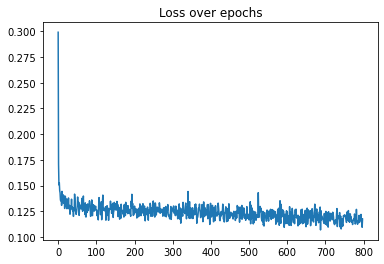

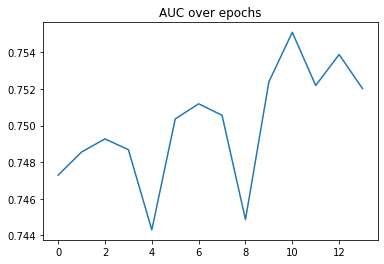

In [11]:
plt.figure(1)
plt.plot(losses_history)
plt.title("Loss over epochs")

plt.figure(2)
plt.plot(val_aucs)
plt.title("AUC over epochs")

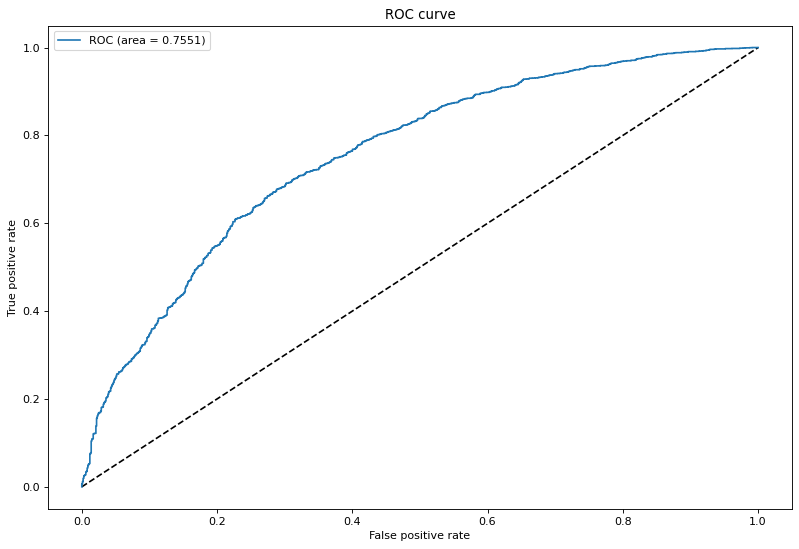

In [12]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_labels_last, outs_preds)
auc_score = auc(fpr_keras, tpr_keras)
# This one reports too high auc...
#auc_score = roc_auc_score(val_labels_last, outs_preds)

plt.figure(3, figsize=(12,8), dpi=80)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.4f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [13]:

# plt.figure(4, figsize=(12,8), dpi=80)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.scatter(val_latency_last[:2000], outs_latency[:2000])
# plt.xlabel('True value')
# plt.ylabel('Prediction')
# plt.title('MAE = %.3f\nR2 score = %.3f' % (mean_absolute_error(val_latency_last, outs_latency), r2_score(val_latency_last, outs_latency)))
# plt.show()

torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000, 1])
torch.Size([1, 1000, 1])
index index: 50


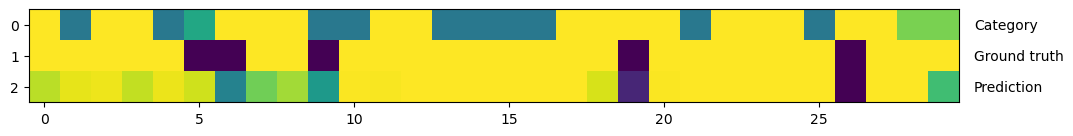

In [14]:
idx = 50
with h5py.File(INPUT_PATH,'r') as h5_file:
  exercises_test = torch.from_numpy(h5_file['exercises_test'][idx:idx+1]).long().cuda()
  exercise_ids_test = torch.from_numpy(h5_file['exercise_ids_test'][idx:idx+1]).long().cuda()
  labels_test = h5_file['labels_test'][idx:idx+1]
  shifted_label_test = torch.roll(torch.from_numpy(labels_test), 1).long().cuda()
  shifted_label_test[:,0] = 2  
  elapsed_test = h5_file['elapsed_test'][idx:idx+1]
  timestamp_test = h5_file['timestamps_test'][idx:idx+1]  
  elapsed = torch.from_numpy(elapsed_test).float().cuda().unsqueeze(2)
  timestamp = torch.from_numpy(timestamp_test).float().cuda().unsqueeze(2)

  print(exercise_ids_test.shape)
  print(exercises_test.shape)
  print(shifted_label_test.shape)
  print(elapsed.shape)  
  print(timestamp.shape)

  outs_pred = model(exercise_ids_test, exercises_test, shifted_label_test, elapsed, timestamp)        

  img_width = TIME_STEPS
  max_width = 30

  ground_truth = labels_test.squeeze()
  pred = outs_pred.squeeze().cpu().detach().numpy()

  # Define image
  img = np.ndarray((3, img_width))
  img = img[:, :max_width]

  # Set category color
  ex_color = exercises_test.squeeze().cpu().detach().numpy()
  color_dict = dict(enumerate(list(set(ex_color))))
  color_dict = {v:k for k,v in color_dict.items()}
  colors = list(map(lambda x: (color_dict[x] + 1)/len(color_dict.keys()), ex_color))
  colors = colors[-max_width:]
  img[0,:] = colors

  # Set ground truth color
  ground_truth = ground_truth[-max_width:]
  img[1,:] = ground_truth

  # Set prediction color
  pred = pred[-max_width:]
  img[2,:] = pred

  # Show the figure
  plt.figure(4, figsize=(12,8), dpi=100)
  plt.imshow(img)
  plt.text(max_width, 0.15, "Category")
  plt.text(max_width, 1.15, "Ground truth")
  plt.text(max_width, 2.15, "Prediction")

  # Index
  print("index index: %i" % idx)